**Data Validation**

This data set has 947 rows, 8 columns. I have validated all variables and I have made some changes after validation.

1. recipe: recipe is the unique numeric identifier as described in the data dictionary. The values range sequentially from 1 to 947 without missing values. Type of variable is integer. No cleaning is needed
   
2. category:  category is the type of recipe. Unlike expected, it consists of 11 unique groups without missing values. Additionally, the chicken breast group was identified. As a result, category names are Pork,Potato, Breakfast, Beverages, One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, Vegetable, Meat and Dessert. Object type of variable of the dataframe converted to nominal category type.
   
3. servings: Number of servings for the recipe.In the dataframe this variable appears as an object without missing values, which should be numeric. It has also some inconsistent records like '4 as a snack', '6 as a snack'. In order to clean the data, the inconsistent records were first replaced with their numerical equivalents and then converted to integer. After cleaning stage, serving groups are 1, 2, 4 and 6. We can call this variable as numerical categorical variable
   
4. high_traffic: in the data dictionary it described as "if the traffic to the site was high when this recipe was shown, this is marked with 'High' ". 
   - Values defined as 'High' were seen. Additionally, missing NaN values detected. 
   - There are 574 High Values and 373 NaN (missing) values.
   - In this case, it seems that the NaN values here represent normal traffic. Therefore, I filled the NaN values to Normal for now. In the following stages it will be our target variable, I will apply the preprocessing step to this   column again.
   - As a result, There are 574 High traffic values and 373 Normal traffic values. 
  
5. calories: Numeric number of calories per serving as expected. But it has 52 missing values. Type of variable is float64.
   
6. carbohydrate: Numeric, amount of carbohydrates in grams per serving as expected. But it has 52 missing values. Type of variable is float64.
   
7. sugar: Numeric, amount of sugar in grams per serving as expected. But it has 52 missing values. Type of variable is float64.

8. protein: Numeric, amount of protein in grams per serving as expected. But it has 52 missing values. Type of variable is float64.

Missing values that occurred simultaneously in items 5, 6, 7 and 8 were detected. For this reason, calories, carbohydrate, sugar and protein variables were evaluated together.

Conclusion:

- Missing data were examined categorically and on a target variable basis. According to this;
1. Missing data occurred simultaneously in the variables calories, carbohydrate, sugar and protein and is in 52 rows.
2. Missing data occurred in the categories Pork,Potato, One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, Vegetable, Meat and Dessert. There is no missing data in the Breakfast and Beverages categories.
3. In the high_traffic variable, 39 of the missing data are in the High category and 13 of them are in the Normal category.

The reason why missing data are in certain categories and numerical variables are present at the same time may be due to a systematic error in the data collection phase in the relevant categories.

Since the missing data was in the calories, carbohydrate, sugar and protein variables at the same time, and because it was approximately 5% of the entire data set, and finally, deleting it would not affect the class balance in the target variable high_traffic, I cleaned these missing data by removing them from the data set. 

After the cleaning stage the cleaned data has 895 rows and 8 columns without missing values.

In [754]:
import warnings
warnings.filterwarnings("ignore")
import missingno as msno
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error,make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE,SelectKBest,f_regression
from sklearn.decomposition import PCA
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials
from tqdm import tqdm
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [755]:
df = pd.read_csv('data/recipe_site_traffic_2212.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [756]:
df.shape

(947, 8)

**1. Reecipe Variable**

In [757]:
# validate 947 unique values
df["recipe"].nunique()

947

**2. Category Variable**

In [758]:
# validate 11 categories
df["category"]= df["category"].astype('category')
df["category"].value_counts()

category
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Dessert            83
Vegetable          83
Meat               79
Chicken            74
One Dish Meal      71
Name: count, dtype: int64

**3. Servings Variable:**

In [759]:
df["servings"].value_counts()

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64

In [760]:
# validate 1, 2, 4, 6 servings group
df["servings"].replace({'4 as a snack':'4','6 as a snack':'6'},inplace=True)
df["servings"] = df["servings"].astype(int)
df["servings"].value_counts()

servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64

**4. High_traffic Variable**

In [761]:
df["high_traffic"].value_counts(dropna=False)

high_traffic
High    574
NaN     373
Name: count, dtype: int64

In [762]:
df["high_traffic"].fillna('Normal',inplace=True)
df["high_traffic"]= df["high_traffic"].astype('category')
df["high_traffic"].value_counts()

high_traffic
High      574
Normal    373
Name: count, dtype: int64

**5, 6, 7 and 8 Variables Missing Values Analysis**

In [763]:
df.isnull().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

- Missing values occur simultaneously in calories, carbohydrate, sugar and protein variables of data

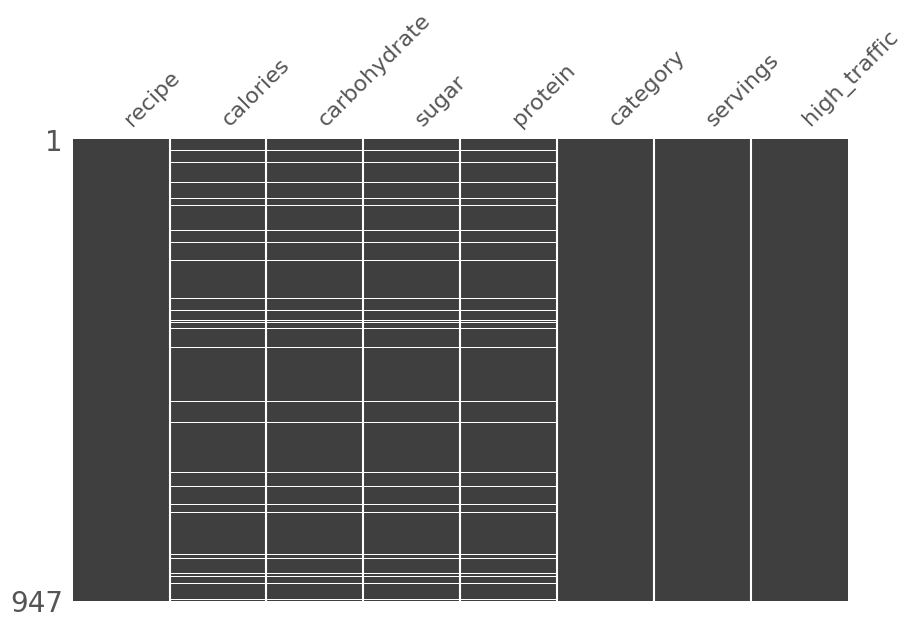

In [764]:
fig, ax = plt.subplots(figsize=(10, 6))  
msno.matrix(df, ax=ax)  
plt.show()

- Validation that missing data occur simultaneously. Total count is 52

In [765]:
df.loc[df.select_dtypes(include='float64').isnull().all(axis=1),"category"].count()

52

- Category-based analysis of missing data

General category distribution: 
- Although the Breakfast vs Chicken Breast categories are at the forefront, the categories seem to be approximately balanced.

In [766]:
#Percentage distributions of categories
df["category"].value_counts(normalize=True) * 100

category
Breakfast         11.193242
Chicken Breast    10.348469
Beverages          9.714889
Lunch/Snacks       9.398099
Potato             9.292503
Pork               8.870116
Dessert            8.764520
Vegetable          8.764520
Meat               8.342133
Chicken            7.814150
One Dish Meal      7.497360
Name: proportion, dtype: float64

Category distribution of missing values: 
- It was determined that missing data was more in the Pork and Lunch/Snacks categories and there was no missing data in the Beverages and Breakfast categories.Additionally, the rate of categories with missing data is quite low compared to other categories.

In [767]:
#Percentage distributions of categories with missing numeric values
df.loc[df.select_dtypes(include='float64').isnull().all(axis=1),"category"].value_counts(normalize=True) * 100

category
Pork              21.153846
Lunch/Snacks      13.461538
Dessert           11.538462
Chicken            9.615385
Meat               9.615385
Potato             9.615385
Vegetable          9.615385
Chicken Breast     7.692308
One Dish Meal      7.692308
Beverages          0.000000
Breakfast          0.000000
Name: proportion, dtype: float64

Related Visualizations that mentioned above. Bar plots show the counts of each categories

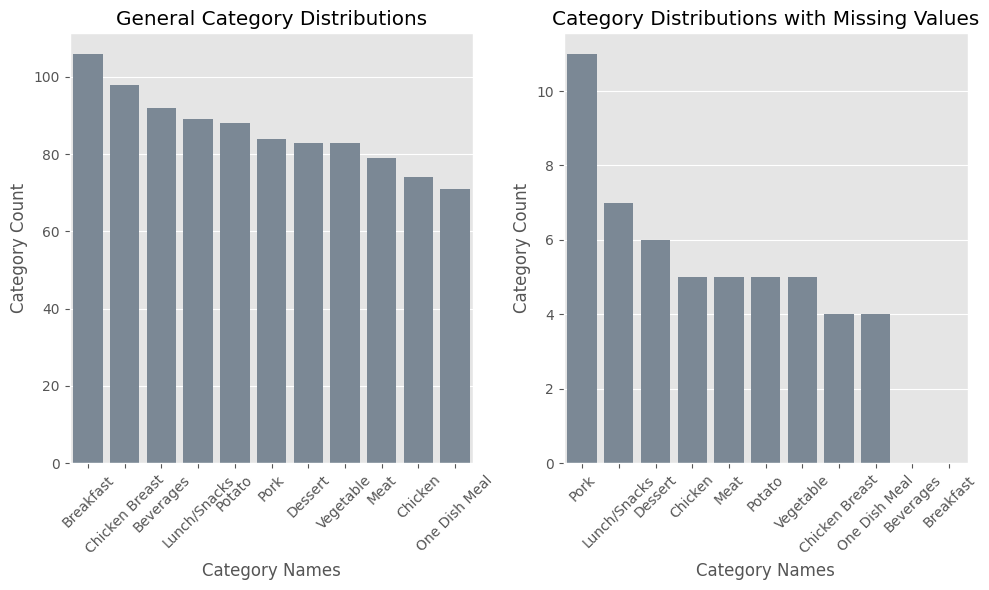

In [768]:
category_counts = df["category"].value_counts()
missing_value_category_counts = df.loc[df.select_dtypes(include='float64').isnull().all(axis=1),"category"].value_counts()

fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

axs[0]=sns.barplot(x=category_counts.index, y=category_counts,color='lightslategrey',order=category_counts.index,ax=axs[0])
axs[0].set_title('General Category Distributions')
axs[0].set_xlabel('Category Names')
axs[0].set_ylabel('Category Count')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

axs[1]=sns.barplot(x=missing_value_category_counts.index,y=missing_value_category_counts,order=missing_value_category_counts.index,color='lightslategrey',ax=axs[1])
axs[1].set_title('Category Distributions with Missing Values')
axs[1].set_xlabel('Category Names')
axs[1].set_ylabel('Category Count')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

- Target variable-based analysis of missing data

General high_traffic distribution:
- There are 574 High traffic values and 373 Normal traffic values in the general of the data.

In [769]:
df["high_traffic"].value_counts()

high_traffic
High      574
Normal    373
Name: count, dtype: int64

Missing values at high traffic distribution:
 - It was determined that 39 of the 52 missing data that occurred simultaneously in the calories, carbohydrate, sugar and protein variables were in the High category and 13 of them were in the normal category.

In [770]:
df.loc[df.select_dtypes(include='float64').isnull().all(axis=1),"high_traffic"].value_counts()

high_traffic
High      39
Normal    13
Name: count, dtype: int64

Conclusion about missing values:

- Missing data were examined categorically and on a target variable basis. According to this
1. Missing data occurred simultaneously in the variables calories, carbohydrate, sugar and protein and is in 52 lines.
2. Missing data occurred in the categories Pork,Potato, One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, Vegetable, Meat and Dessert. There is no missing data in the Breakfast and Beverages categories.
3. In the high_traffic variable, 39 of the missing data are in the High category and 13 of them are in the Normal category.

The reason why missing data are in certain categories and numerical variables are present at the same time may be due to a systematic error in the data collection phase in the relevant categories.

Since the missing data was in the calories, carbohydrate, sugar and protein variables at the same time, and because it was approximately 5% of the entire data set, and finally, deleting it would not affect the class balance in the target variable high_traffic, I cleaned these data by removing them from the data set. 

In [771]:
# Missing data threshold approximately %5 of whole data
threshold = len(df) * 0.055
threshold

52.085

In [772]:
cols_to_drop = df.columns[df.isnull().sum() <= threshold]
df.dropna(subset=cols_to_drop, axis = 0, inplace = True)

In [773]:
df.reset_index(drop=True,inplace=True)

In [774]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int32   
 7   high_traffic  895 non-null    category
dtypes: category(2), float64(4), int32(1), int64(1)
memory usage: 40.8 KB


In [775]:
# Validate no missing values after cleaning the data
df.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [776]:
df.shape

(895, 8)

- Final cleaned data

In [777]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,2,35.48,38.56,0.66,0.92,Potato,4,High
1,3,914.28,42.68,3.09,2.88,Breakfast,1,Normal
2,4,97.03,30.56,38.63,0.02,Beverages,4,High
3,5,27.05,1.85,0.80,0.53,Beverages,4,Normal
4,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


In [778]:
# Validate any negative values in numeric variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recipe,895.0,473.652514,272.763283,2.00,237.500,475.00,708.500,947.00
calories,895.0,435.939196,453.020997,0.14,110.430,288.55,597.650,3633.16
carbohydrate,895.0,35.069676,43.949032,0.03,8.375,21.48,44.965,530.42
sugar,895.0,9.046547,14.679176,0.01,1.690,4.55,9.800,148.75
protein,895.0,24.149296,36.369739,0.00,3.195,10.80,30.200,363.36
servings,895.0,3.458101,1.735979,1.00,2.000,4.00,4.000,6.00


**Explatory Analysis**

- Defining the functions used in explatory analysis

In [779]:
# Plot Function 
def single_variable_multiple_plot(data,type='float64',color='lightslategrey',numeric=True):
    """
    Visualizes a single variable in the dataset using histogram, box plot, and kernel density estimate (for numeric variables) 
    or count plot and pie chart (for categorical variables).

    Parameters:
    data : DataFrame
        The dataset.
    type : str, optional
        Data type of numerical variables. Default is 'float64'.
    color : str, optional
        Color palette for the plots. Default is 'lightslategrey'.
    numeric : bool, optional
        If True, plots will be created for numerical variables; if False, plots will be created for categorical variables. Default is True.

    Returns:
    None
    """
    if numeric: 
         numeric_columns= [col for col in data.columns if data[col].dtype == type]
         for i in numeric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
            sns.histplot(x=data[i],bins=10,ax=axes[0],color=color)
            axes[0].set_title(i)
            sns.boxplot(x=data[i],ax=axes[1],color=color)
            axes[1].set_title(i)
            sns.kdeplot(x=data[i],ax=axes[2],color=color)
            axes[2].set_title(i)
            plt.show()
    
    else:
         categoric_columns= [col for col in data.columns if data[col].dtype in ['object','category','int32']]
         for i in categoric_columns:
            fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
            sns.countplot(data=data, x=i,color=color,order=data[i].value_counts().index, ax=axes[0])
            axes[0].set_title(i)
            axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
            plt.pie(data[i].value_counts(), autopct='%1.1f%%', colors=['lightblue', 'lightcoral', 'lightgreen', 'lightsalmon', 'lightpink'],labels=data[i].value_counts().index)
            axes[1].set_title(i)
            axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
            plt.tight_layout()
            plt.show()

In [780]:
# Outlier function

def outlier_thresholds(dataframe, variable, q1_thr=0.25, q3_thr=0.75):
    """
    Calculate the lower and upper bounds to cap outliers in a variable.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame containing the variable.
    variable : str
        The name of the variable for which to calculate the outlier thresholds.
    q1_thr : float, optional
        The quantile value for the lower quartile. Default is 0.25.
    q3_thr : float, optional
        The quantile value for the upper quartile. Default is 0.75.

    Returns
    -------
    low_limit : float
        The lower bound threshold for capping outliers.
    up_limit : float
        The upper bound threshold for capping outliers.
    """
    quartile1 = dataframe[variable].quantile(q1_thr)
    quartile3 = dataframe[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

**Analysis of continuous numerical variables**

- Investigation of calories, carbohydrate, sugar and protein variables distribution
  
When I looked at the summary statistics, I saw that the median values in these 4 variables were lower than the average. This gave me the impression that these variables were all skewed to the right. When I look at the minimum and maximum values, I see that these values are far from the average and median. Also, standard deviations are very high. This may be due to outliers in the data set.

To deal with this situation, I visualized these numerical variables one by one and looked at their distribution. Then I did an outlier analysis.

To visualize the distribution, I chose histogram, kdeplot and boxplot. Since the histogram is affected by binning bias, I will look at it together with the kernel density estimation chart, which reveals the distribution more clearly. I added the boxplot to visualize outliers.

After the visualizations, it was more clearly determined that the distributions were skewed to the right and there were outliers.



In [781]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,2,35.48,38.56,0.66,0.92,Potato,4,High
1,3,914.28,42.68,3.09,2.88,Breakfast,1,Normal
2,4,97.03,30.56,38.63,0.02,Beverages,4,High
3,5,27.05,1.85,0.80,0.53,Beverages,4,Normal
4,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


In [782]:
df.describe(include='float64').T

,count,mean,std,min,25%,50%,75%,max
calories,895.0,435.939196,453.020997,0.14,110.430,288.55,597.650,3633.16
carbohydrate,895.0,35.069676,43.949032,0.03,8.375,21.48,44.965,530.42
sugar,895.0,9.046547,14.679176,0.01,1.690,4.55,9.800,148.75
protein,895.0,24.149296,36.369739,0.00,3.195,10.80,30.200,363.36


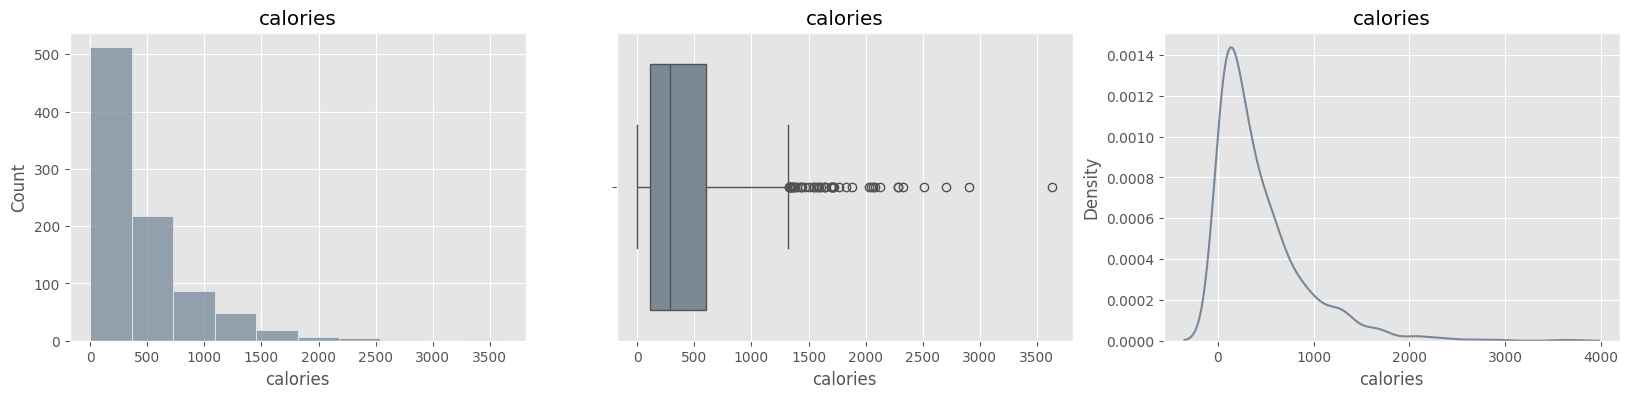

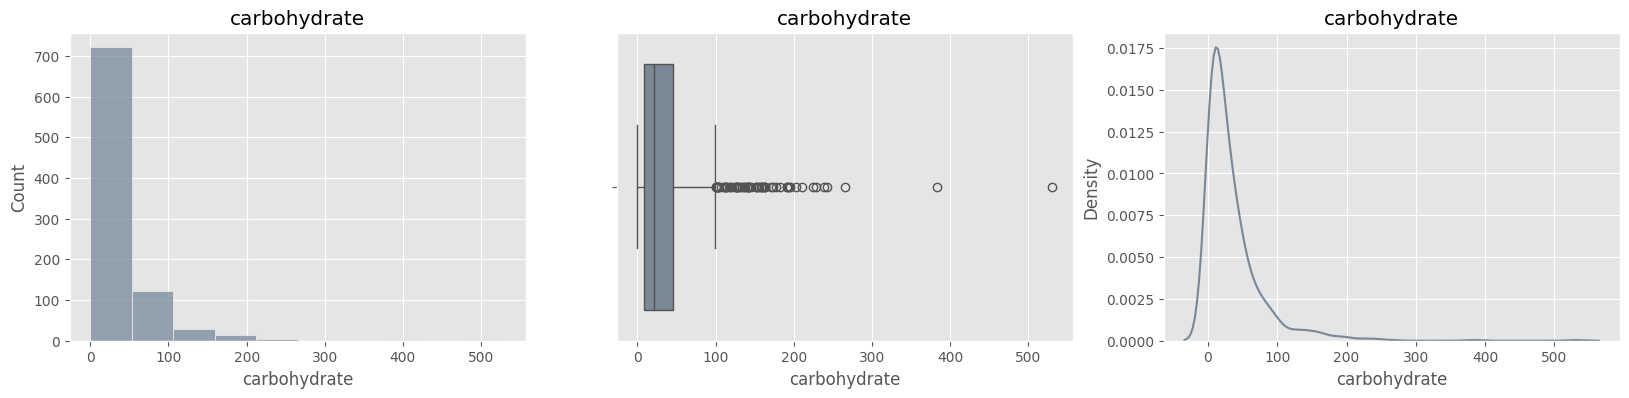

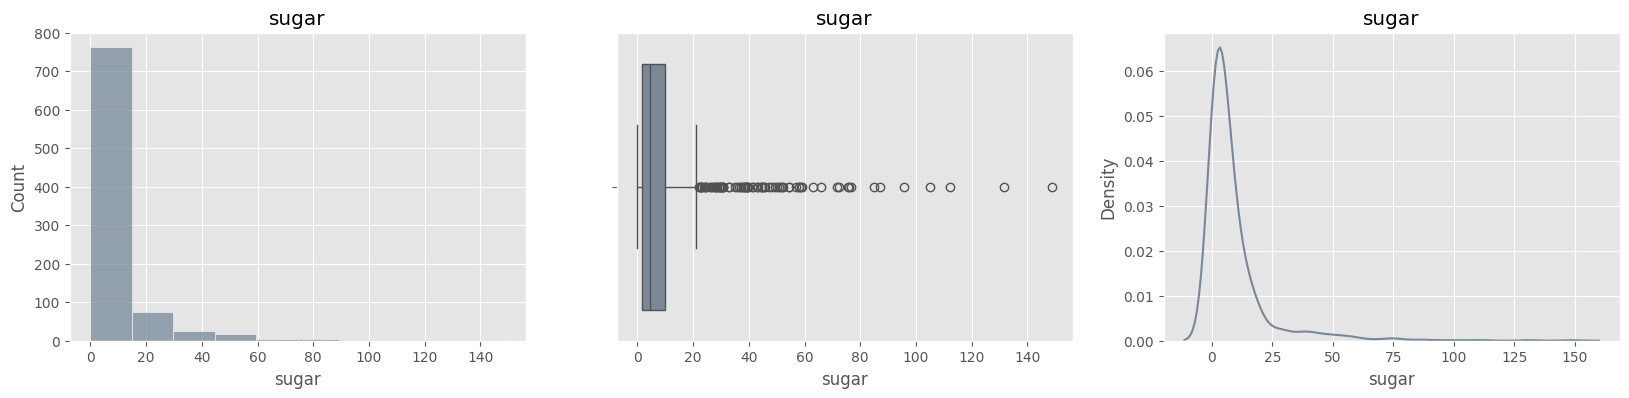

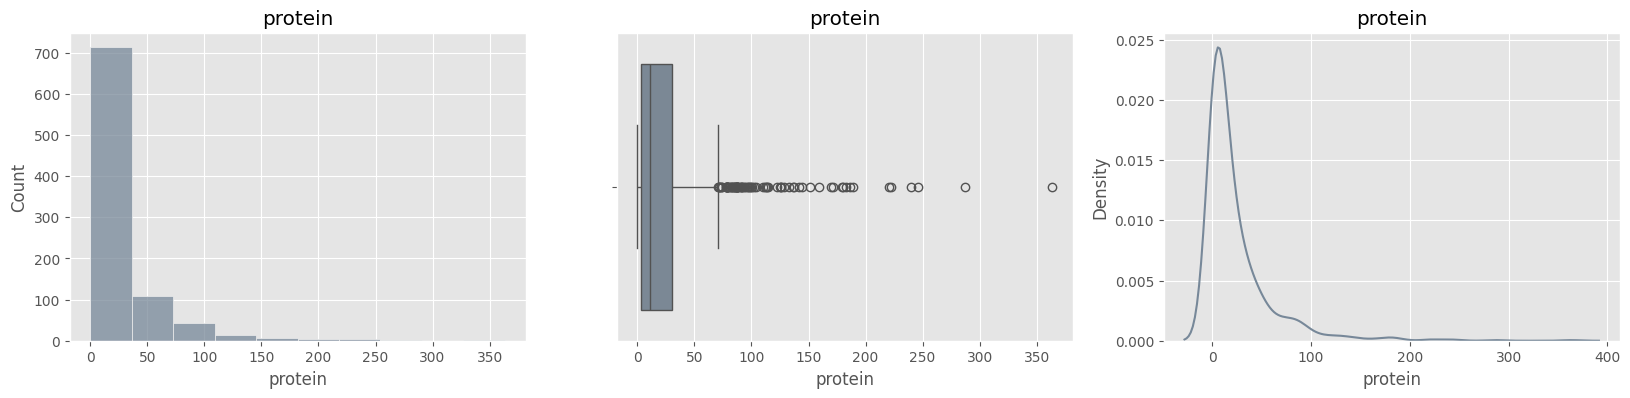

In [783]:
single_variable_multiple_plot(df,"float64")

- Outlier analysis of carbonhydrate, sugar, protein and calories variables
  
I preferred the iqr method because the distribution does not need to be transformed and is sensitive to outliers.
  

- carbonhydrate variable outlier analysis:

When applying iqr for this variable, I chose a lower and upper limit based on quarterly values of 25% for q1 and %75 for q3. Since my low_limit was negative, I did not change at the lower values and 
capped the upper limit to the up_limit value.
As a result i capped 58 of outlier values to the up_limit (99.85) value to avoid data loss



In [784]:
low_limit, up_limit = outlier_thresholds(df,"carbohydrate")
df[(df["carbohydrate"] < low_limit) | (df["carbohydrate"] > up_limit)].shape

(58, 8)

In [785]:
df.loc[(df["carbohydrate"] > up_limit), "carbohydrate"] = up_limit

- sugar variable outlier analysis:

When applying iqr for this variable, I chose a lower and upper limit based on quarterly values of 25% for q1 and %75 for q3. Since my low_limit was negative, I did not change at the lower values and capped the upper limit to the up_limit value.
As a result i capped 79 of outlier values to the up_limit (21.96) value to avoid data loss

In [786]:
low_limit, up_limit = outlier_thresholds(df,"sugar")
df[(df["sugar"] < low_limit) | (df["sugar"] > up_limit)].shape

(79, 8)

In [787]:

df.loc[(df["sugar"] > up_limit), "sugar"] = up_limit

- protein variable outlier analysis:

When applying iqr for this variable, I chose a lower and upper limit based on quarterly values of 25% for q1 and %75 for q3. Since my low_limit was negative, I did not change at the lower values and capped the upper limit to the up_limit value. As a result i capped 77 of outlier values to the up_limit (70.70) value to avoid data loss

In [788]:
low_limit, up_limit = outlier_thresholds(df,"protein")
df[(df["protein"] < low_limit) | (df["protein"] > up_limit)].shape

(77, 8)

In [789]:
df.loc[(df["protein"] > up_limit), "protein"] = up_limit

- calories variable outlier analysis:

The same method was used in the analysis of this variable. Lower and upper limits have been determined. Since the lower limit was negative, it was not taken into account. The upper limit is determined as 1328.48 according to the 75% quarter. The 47 outlier high values were replaced accordingly.

For determining the lower limit, I saw inconsistently low calorie values.

As a result of my research for this purpose, I saw that the 4-9-4 system, developed by chemist Wilbur Atwater in the United States in the 19th century, was generally used to calculate caloric value. According to this system, proteins and carbohydrates each have about 4 calories per gram and fats have 9 calories per gram.

If we apply the formula to our dataset, the formula will be as follows, since sugar is also included in the carbohydrate class:
calorie = protein x 4 + carbonhydrate x 4 + sugar x 4 + fat x 9

The fat variable is not given in our data set. But we can create a fat variable using this formula.

To get a general idea, I grouped the data set according to category and servings and obtained the median values of calories, protein, sugar, carbohydrate variables and calculated calories without the fat variable.

The result I got shows that if we had a fat variable, we could obtain approximately the caloric value.

In line with this information, I created the variable calories_with_fat_is_1 by using the calorie formula and accepting the fat variable as constant 1. When I queried the calorie variables smaller than this variable, I detected calorie values in 357 rows that were smaller than the value calculated from the formula. Caloric values should be equal to or more than the value calculated from the formula.

It may be a solution to cap the 357 detected rows to the value calculated from the formula, but since the number of data is higher according to whole data set, we need to discuss this issue with the product team. For now,  I capped these values that are less than 20 calories to the value that calculated from the formula. 41 value changed.

I tried creating a fat variable but for this reason I got more than 300 negative values. Therefore, I gave up adding the fat variable.





In [790]:
low_limit, up_limit = outlier_thresholds(df,"calories")
df[(df["calories"] < low_limit) | (df["calories"] > up_limit)].shape

(47, 8)

In [791]:
# outliers capped to the upper limit
df.loc[(df["calories"] > up_limit), "calories"] = up_limit

In [792]:
# inconsistent low calorie values
df[(df["calories"] < 20)].head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
19,21,9.26,17.44,8.16,10.81,Potato,6,High
55,59,6.23,56.43,5.60,2.12,Lunch/Snacks,6,High
76,80,19.91,35.47,2.17,11.82,Breakfast,1,High
131,140,13.62,92.02,0.89,44.92,One Dish Meal,1,High
132,141,4.22,3.46,10.93,0.74,Beverages,6,Normal


In [793]:
# calories without fat
# it validates that if we had fat variable we could approximately calculate the calorie variable
grouped_df = df.groupby(['category','servings'])[['calories','protein','sugar','carbohydrate']].median().reset_index().head()
grouped_df["calories_without_fat"] = (grouped_df["protein"] * 4) + (grouped_df["sugar"] * 4) + (grouped_df["carbohydrate"] * 4)
grouped_df.head()

,category,servings,calories,protein,sugar,carbohydrate,calories_without_fat
0,Beverages,1,154.465,0.400,9.385,11.120,83.62
1,Beverages,2,199.340,0.560,7.580,13.870,88.04
2,Beverages,4,129.450,0.405,9.885,12.415,90.82
3,Beverages,6,88.170,0.400,6.470,8.840,62.84
4,Breakfast,1,253.465,13.975,3.590,28.850,185.66


In [794]:
# new calories_with_fat_is_1 varible is created for cap the inconsistent variables below the 20 calorie. fat value assumed 1 for every variable.
df["calories_with_fat_is_1"] = (df["protein"] * 4) + (df["sugar"] * 4) + (df["carbohydrate"] * 4) + 9
# calorie values filtered as lower than calories_with_fat_is_1 and lower than 20 calorie value
filtered_df = df[(df["calories"] < df["calories_with_fat_is_1"]) & (df["calories"] <= 20)]
# new calculated values overwrited on calories that below the 20
df.loc[filtered_df.index, "calories"] = filtered_df["calories_with_fat_is_1"]
# finally i dropped the calculated column
df.drop("calories_with_fat_is_1",axis=1,inplace=True)

In [795]:
# Validation of outlier analysis performed on calories, carbonhydrate, sugar and protein variables.
df.describe(include='float64').T

,count,mean,std,min,25%,50%,75%,max
calories,895.0,423.717184,370.963353,20.81,130.290,299.14,597.650,1328.4800
carbohydrate,895.0,31.083430,28.945415,0.03,8.375,21.48,44.965,99.8500
sugar,895.0,6.834866,6.624471,0.01,1.690,4.55,9.800,21.9650
protein,895.0,20.124053,22.111812,0.00,3.195,10.80,30.200,70.7075


Bunu genel plot bölümüne taşı

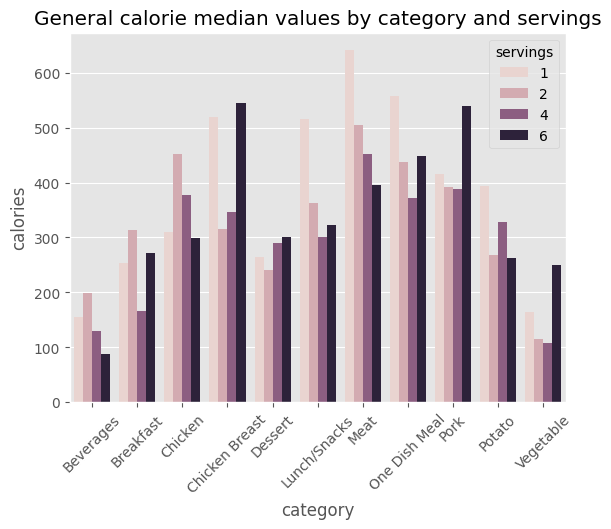

In [658]:
category_serving_group_by_calories = df.groupby(['category','servings'])['calories'].median().reset_index()
sns.barplot(x= 'category', y='calories',hue='servings', data=category_serving_group_by_calories)
plt.title("General calorie median values by category and servings")
plt.xticks(rotation=45)
plt.show()

In [292]:
#sns.pairplot(data=df,hue="high_traffic")

**Analysis of categorical variables**

Investigation of category, servings and high trafic variables distribution: 
I chose countplot to see categorical variables numerically and pie plot to see them as percentages.

- category variable:
Although the categories of breakfast, chicken breast, and beverages stand out slightly in percentage terms, it seems that the category distribution is generally balanced.

- servings variable:
Servings category 4-person recipes stand out with a 41% significant difference. This may indicate that the recipes are preferred more by small families.

- high_traffic variable:
The fact that approximately 60% of the samples are High and 40% are Normal shows that we are faced with a class imbalance problem. This situation is discussed in detail in the model section.


In [796]:
df["high_traffic"].value_counts()

high_traffic
High      535
Normal    360
Name: count, dtype: int64

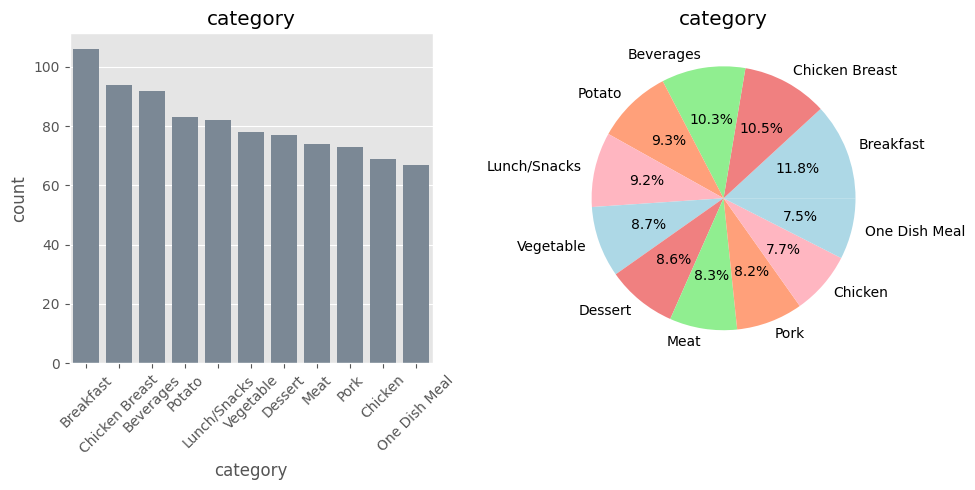

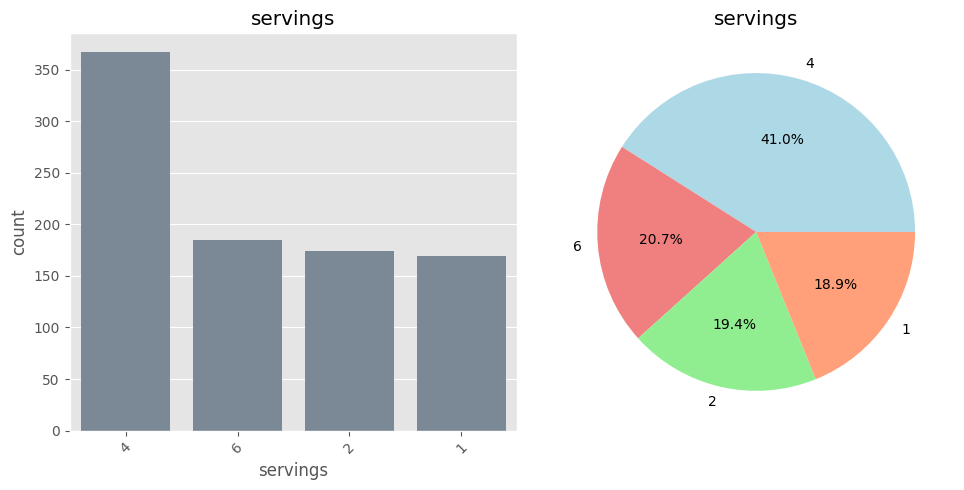

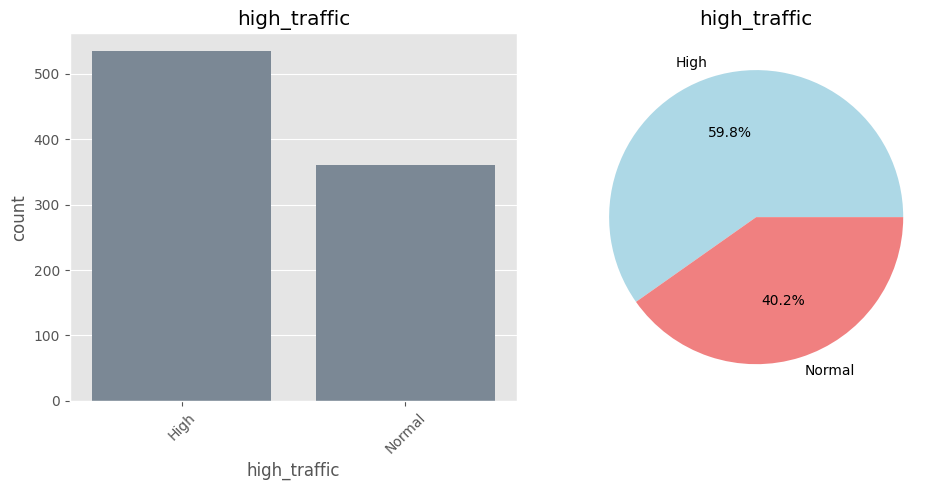

In [278]:
single_variable_multiple_plot(df,numeric=False)

**General visualizations**